# PFAM Annotation Module

Este notebook demuestra el uso de los dos métodos principales del módulo `pfam_annotation.py` de pyMut.


## 1. Importar librerías y cargar datos


In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Añadir el directorio src al path para importar pyMut
sys.path.insert(0, '../src')

# Importar pyMut
from pyMut import read_maf
from pyMut.utils.database import build_embedded_db

# Cargar datos de ejemplo
maf_file = "../src/pyMut/data/examples/tcga_laml_VEP_annotated.maf.gz"
maf_data = read_maf(maf_file)

# Configurar base de datos PFAM
try:
    build_embedded_db(force_rebuild=False)
except:
    pass


2025-07-10 19:47:35,502 | INFO | pyMut.input | Starting MAF reading: ../src/pyMut/data/examples/tcga_laml_VEP_annotated.maf.gz
2025-07-10 19:47:35,502 | INFO | pyMut.input | Loading from cache: ../src/pyMut/data/examples/.pymut_cache/tcga_laml_VEP_annotated.maf_ff3cb9f330528ff5.parquet
2025-07-10 19:47:35,543 | INFO | pyMut.input | Cache loaded successfully in 0.04 seconds


✅ Database already exists at /home/luisruimore/Escritorio/pyMut/examples/../src/pyMut/data/resources/data.duckdb


## 2. Uso del método annotate_pfam()


In [2]:
# Anotar variantes con dominios PFAM
maf_data = maf_data.annotate_pfam()

# Mostrar ejemplos de anotaciones
if 'pfam_id' in maf_data.data.columns:
    pfam_examples = maf_data.data[
        maf_data.data['pfam_id'].notna()
    ][['Hugo_Symbol', 'Protein_Change', 'uniprot', 'aa_pos', 'pfam_id', 'pfam_name']].head(10)
    display(pfam_examples)


📊 Data availability check:
   UniProt column: ✓
   AA position column: ✗
   VEP_DOMAINS: ✓
   Protein_Change: ✓
🔗 Extracting amino acid positions from Protein_Change...
🎯 Using database annotation (most precise)
📊 Annotating 890 variants with PFAM domains...
🔍 Using SQL for PFAM annotation...
✓ Variantes anotadas con PFAM: 334/890


,Hugo_Symbol,Protein_Change,uniprot,aa_pos,pfam_id,pfam_name
0,ABCA10,p.K960R,P42694,960.0,PF00003,PF00003
1,ABCC11,p.I490I,Q96J66,490.0,PF00501,PF00501
2,ABCF1,p.G658S,P36915,658.0,PF00501,PF00501
3,ABCG4,p.Y567C,None,567.0,PF00503,PF00503
4,ABL1,p.P918L,P52735,918.0,PF00581,PF00581
5,ACAT1,p.T185T,Q93034,185.0,PF00996,PF00996
6,ACOXL,p.A46V,None,46.0,PF01007,PF01007
7,ACSM2A,p.G247D,Q08AH3,247.0,PF01007,PF01007
8,ACSS3,p.A266V,O75334,266.0,PF01150,PF01150
9,ACTL7A,p.G426R,None,426.0,PF01150,PF01150


## 3. Uso del método pfam_domains()


📊 Summarizing PFAM domains (summarize_by=PfamDomain, top_n=10)
📊 Using PFAM columns: pfam_id, pfam_name
📊 Found 334 variants with PFAM domain annotations


,pfam_id,pfam_name,n_genes,n_variants
138,PF04118,PF04118,21,22
36,PF00271,PF00271,4,6
51,PF00520,PF00520,6,6
152,PF07679,PF07679,5,5
187,PF13853,PF13853,4,5
15,PF00069,PF00069,4,4
7,PF00028,PF00028,4,4
35,PF00270,PF00270,4,4
13,PF00063,PF00063,4,4
22,PF00096,PF00096,3,3


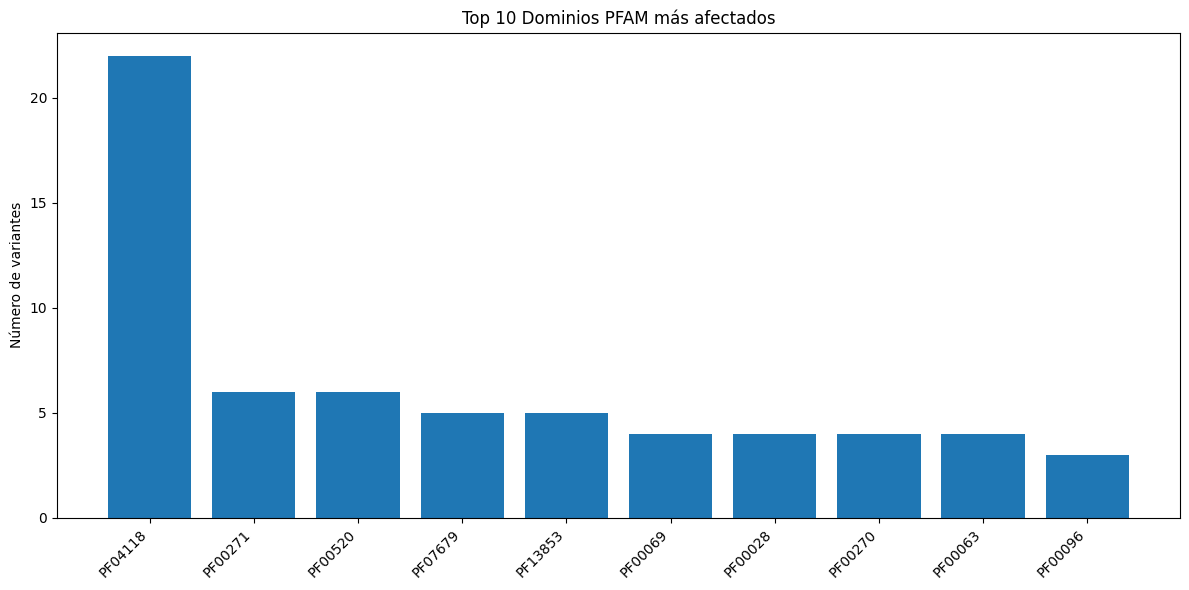

📊 Summarizing PFAM domains (summarize_by=AAPos, top_n=10)
📊 Using PFAM columns: pfam_id, pfam_name
📊 Found 334 variants with PFAM domain annotations


,uniprot,aa_pos,pfam_id,pfam_name,n_variants,n_genes
20,O60941,615.0,PF03016,PF03016,2,1
1,A8MZ26,351.0,PF22956,PF22956,1,1
2,O00451,24.0,PF03137,PF03137,1,1
3,O00585,2.0,PF04118,PF04118,1,1
0,A6NE01,163.0,PF13927,PF13927,1,1
4,O00748,594.0,PF04118,PF04118,1,1
5,O14494,150.0,PF03250,PF03250,1,1
7,O15084,355.0,PF02221,PF02221,1,1
6,O15040,835.0,PF00176,PF00176,1,1
9,O15439,144.0,PF12796,PF12796,1,1


In [3]:
# Resumen por dominio PFAM
pfam_summary = maf_data.pfam_domains(
    summarize_by='PfamDomain',
    top_n=10,
    include_synonymous=False
)

if not pfam_summary.empty:
    display(pfam_summary)

    # Visualización
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(pfam_summary)), pfam_summary['n_variants'])
    plt.xticks(range(len(pfam_summary)), pfam_summary['pfam_name'], rotation=45, ha='right')
    plt.ylabel('Número de variantes')
    plt.title('Top 10 Dominios PFAM más afectados')
    plt.tight_layout()
    plt.show()

# Resumen por posición de aminoácido
aa_summary = maf_data.pfam_domains(
    summarize_by='AAPos',
    top_n=10,
    include_synonymous=False
)

if not aa_summary.empty:
    display(aa_summary)


In [4]:
# Intentar construir la base de datos embebida
print("Configurando base de datos PFAM...")
try:
    # Esto creará la base de datos si no existe
    build_embedded_db(force_rebuild=False)
    print("✓ Base de datos PFAM configurada correctamente")
except Exception as e:
    print(f"⚠️  Error configurando base de datos: {e}")
    print("Continuaremos con las funciones disponibles...")

# Intentar conectar a la base de datos
try:
    db_conn = connect_db()
    print("✓ Conexión a base de datos establecida")

    # Verificar tablas disponibles
    tables = db_conn.execute("SHOW TABLES").fetchall()
    print(f"Tablas disponibles: {[table[0] for table in tables]}")

    db_conn.close()
except Exception as e:
    print(f"⚠️  Error conectando a base de datos: {e}")
    db_conn = None


Configurando base de datos PFAM...
✅ Database already exists at /home/luisruimore/Escritorio/pyMut/examples/../src/pyMut/data/resources/data.duckdb
✓ Base de datos PFAM configurada correctamente
✓ Conexión a base de datos establecida
Tablas disponibles: ['meta', 'pfam', 'xref']
